# MNIST test dataset 

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7
    

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist-weights.h5')
else :
    model = load_model('mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

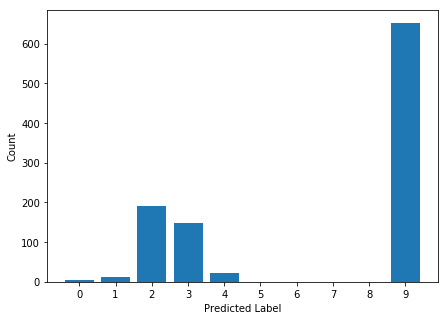

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 67.54 %
Std accuracy: 32.05 %
31.32% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = np.argmax(y_pred_seen, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label_seen[y_pred_label_seen == i] = (i+1)

c = []
for i in range(len(y_pred_label_seen)):
    y_probas_seen = np.sort(y_pred_seen[i])  # probabilities for one image
    c.append(y_probas_seen[-1]-y_probas_seen[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 97.99 %
Std accuracy: 9.79 %
94.32 % of all predictions made with an accuracy higher than 0.95%


# Activation weights visualization

In [8]:
# from https://github.com/keras-team/keras/issues/41

from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

(1, 1, 24, 24, 64)


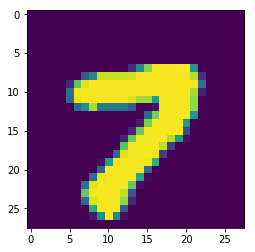

In [9]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

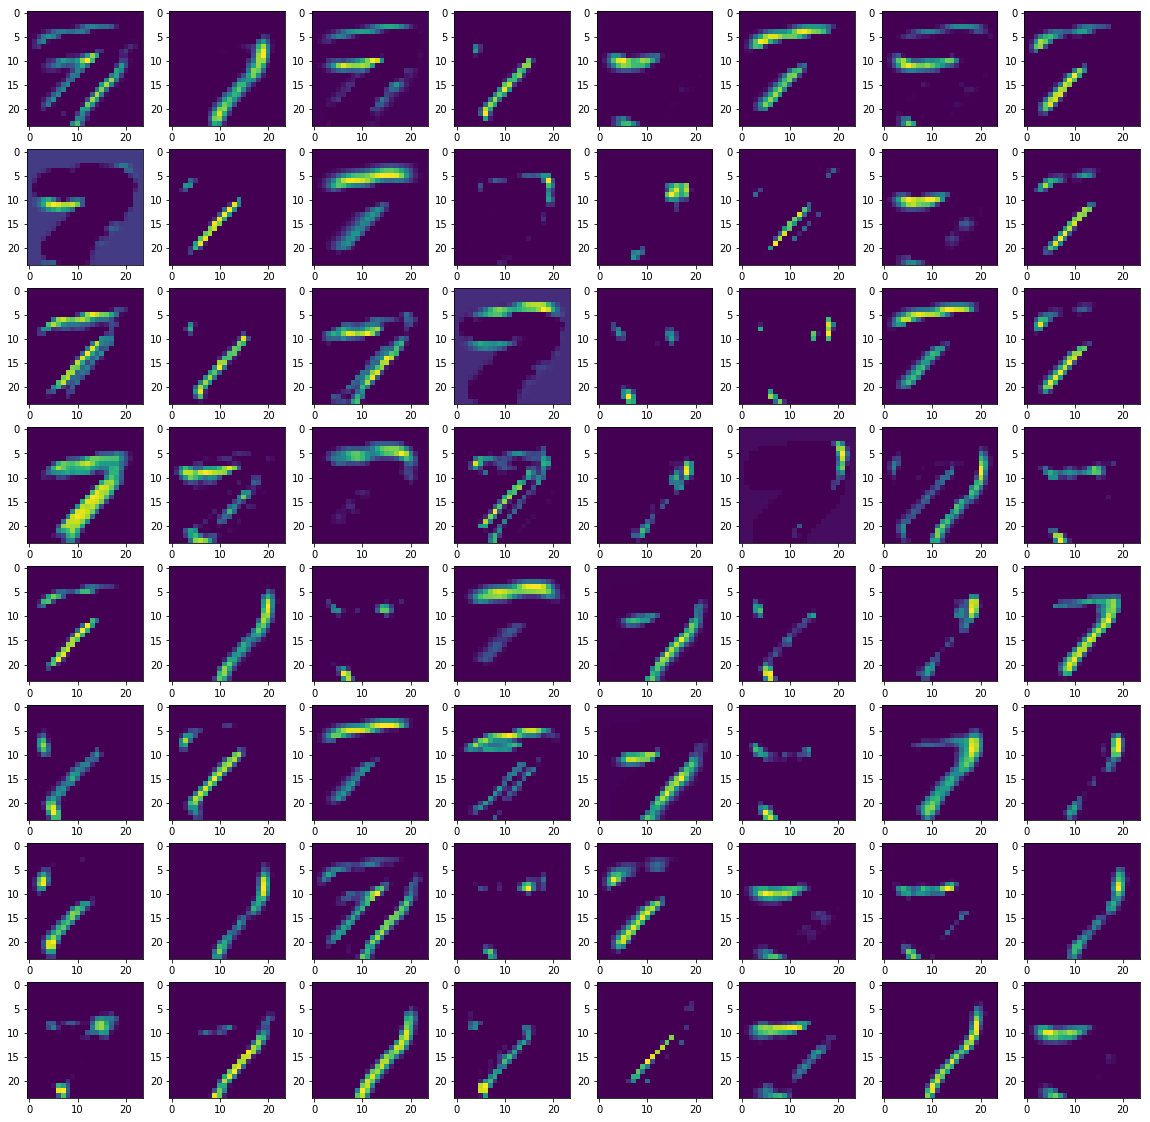

In [10]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

In [11]:
y_test = np.argmax(y_test, axis = 1)

In [12]:
# get activation weights of last layer
activations_unseen_class = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(activations_unseen_class))

n_points = 1000
activations_seen_classes = get_activations(model, 6, x_test[:n_points])[0]
print(np.shape(activations_seen_classes))

activations_all = get_activations(model, 6, x_test_all[:n_points])[0]
print(np.shape(activations_seen_classes))

(1028, 128)
(1000, 128)
(1000, 128)


# Density Tree
Feed activation weigths into density tree

In [13]:
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from sklearn import decomposition
import warnings

Explained variance ratio by first components:
[0.21545272 0.17078644 0.13628493 0.09660039 0.06903908 0.06518693
 0.03590418 0.03409742 0.01733119 0.01320339 0.011413   0.00903188
 0.00768726 0.00685793 0.00657538 0.0060149  0.00546168 0.00499139
 0.00453407 0.004173   0.00388608 0.00364084 0.00329181 0.00301264
 0.00274789 0.00259454 0.00252687 0.00241841 0.00235435 0.00214865]
Variance explained by first 30 components: 0.95


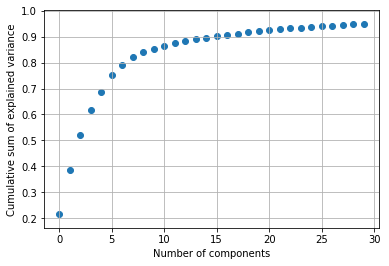

In [14]:
# create density tree for activation weights of training data

dimensions = activations_seen_classes.shape[1]
nclusters = 9

# PCA
n_components = 30
plt.cla()
pca = decomposition.PCA(n_components=n_components)
pca.fit(activations_seen_classes)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [15]:
X_all = pca.transform(activations_all)
X_seen = pca.transform(activations_seen_classes)
X_unseen = pca.transform(activations_unseen_class)

warnings.filterwarnings("ignore")
root = create_density_tree(X_seen, clusters = nclusters)

Next, we can plot the first three components to of the reduced data to search for clusters:

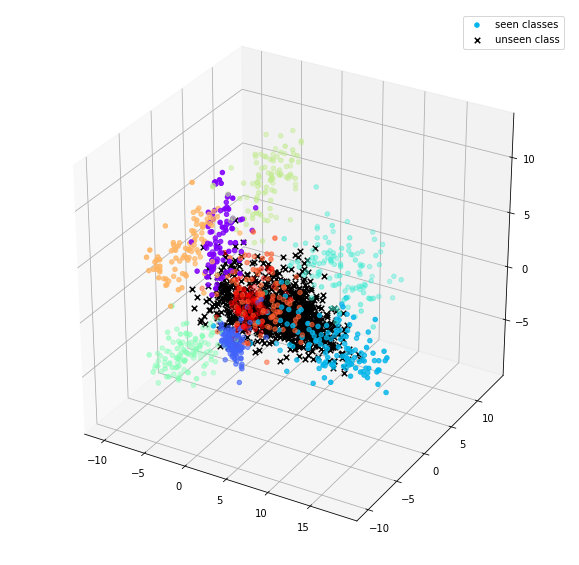

Variance explained by first 3 components: 0.52


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_seen[:,0], X_seen[:,1], zs=X_seen[:,2], c=y_test[:n_points], cmap=plt.get_cmap('rainbow'), s=20)
ax.scatter(X_unseen[:,0], X_unseen[:,1], zs=X_unseen[:,2], c='black', s=30, marker='x', depthshade=False) 
ax.legend(['seen classes','unseen class'])

plt.savefig("../Figures/pca_components_3d.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Since only 54% of the variance is explained in the first 3 components the clusters are hard to discern.

In [17]:
root_nodes_seen = density_forest_create(X_seen, nclusters, n_trees=20, subsample_pct=.3,
                                          n_jobs=1, verbose=10)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


In [19]:
probas_seen = density_forest_traverse(X_seen, root_nodes_seen, thresh=.3)
probas_seen = probas_seen[np.isnan(probas_seen)==False] # only keep non-NaN values

100%|██████████| 1000/1000 [00:04<00:00, 212.98it/s]


In [20]:
probas_unseen = density_forest_traverse(X_unseen, root_nodes_seen, thresh=.2)
probas_unseen = probas_unseen[np.isnan(probas_unseen)==False] # only keep non-NaN values

100%|██████████| 1028/1028 [00:05<00:00, 179.49it/s]


In [21]:
mean_proba_seen = np.mean(probas_seen)
mean_proba_unseen = np.mean(probas_unseen)

std_proba_seen = np.std(probas_seen)
std_proba_unseen = np.std(probas_unseen)

In [22]:
mean_proba_unseen

5.059692350036804e-19

In [23]:
print("Mean probability of unseen class to belong to clusters: %.2f " % (mean_proba_unseen * 1e22))
print("Std probability of unseen class to belong to clusters: %.2f " % (std_proba_unseen * 1e22))

print("Mean probability of seen classes to belong to clusters: %.2f " % (mean_proba_seen * 1e22))
print("Std probability of seen classes to belong to clusters: %.2f " % (std_proba_seen * 1e22))

Mean probability of unseen class to belong to clusters: 5059.69 
Std probability of unseen class to belong to clusters: 56603.60 
Mean probability of seen classes to belong to clusters: 17060779.15 
Std probability of seen classes to belong to clusters: 81601426.75 


In [24]:
print("Ratio unseen / seen: %.2f" % (mean_proba_unseen/mean_proba_seen))
print("Ratio seen / unseen: %.2f" % (mean_proba_seen/mean_proba_unseen))

Ratio unseen / seen: 0.00
Ratio seen / unseen: 3371.90
